In [15]:
# %pip install roboflow supervision -q

In [16]:
import os
from dotenv import load_dotenv

load_dotenv()
from roboflow import Roboflow

# ROBOFLOW_API_KEY = userdata.get('ROBOFLOW_API_KEY')
ROBOFLOW_API_KEY = os.getenv("ROBOFLOW_API_KEY")

rf = Roboflow(api_key=ROBOFLOW_API_KEY)
project = rf.workspace("srinithi-s-tzdkb").project("fracture-detection-rhud5")
version = project.version(4)
dataset = version.download("paligemma")

loading Roboflow workspace...
loading Roboflow project...


{'image': 'n_0_2513_png_jpg.rf.1f679ff5dec5332cf06f6b9593c8437b.jpg', 'prefix': 'detect fracture', 'suffix': '<loc0390><loc0241><loc0472><loc0440> fracture'}


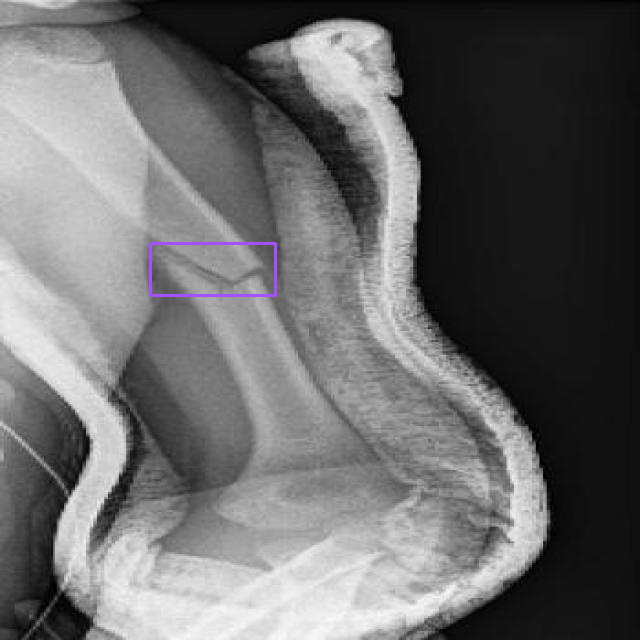

In [17]:
from PIL import Image
import json
import supervision as sv

first = json.loads(
    open(f"{dataset.location}/dataset/_annotations.train.jsonl").readline()
)
print(first)

image = Image.open(f"{dataset.location}/dataset/{first.get('image')}")
CLASSES = first.get("prefix").replace("detect ", "").split(" ; ")
# detections = from_pali_gemma(first.get("suffix"), image.size, CLASSES)
w, h = image.width, image.height
detections = sv.Detections.from_lmm(
    lmm="paligemma",
    result=first.get("suffix"),
    resolution_wh=(w, h),
    classes=CLASSES,
)


sv.BoundingBoxAnnotator().annotate(image, detections)

In [18]:
import os


# TPUs with
if "COLAB_TPU_ADDR" in os.environ:
    raise "It seems you are using Colab with remote TPUs which is not supported."

# Fetch big_vision repository if python doesn't know about it and install
# dependencies needed for this notebook.
if not os.path.exists("big_vision"):
    !git clone --quiet --branch=main --depth=1 \
     https://github.com/google-research/big_vision big_vision_repo
    %mv big_vision_repo/big_vision ./
    %rm -rf big_vision_repo

# Install missing dependencies. Assume jax~=0.4.25 with GPU available.
%pip install -q "overrides" "ml_collections" "einops~=0.7" "sentencepiece"

Note: you may need to restart the kernel to use updated packages.


In [19]:
import os
import kagglehub

MODEL_PATH = "./pt_224_128.params.f16.npz"
if not os.path.exists(MODEL_PATH):
    print("Downloading the checkpoint from Kaggle, this could take a few minutes....")
    # Note: kaggle archive contains the same checkpoint in multiple formats.
    # Download only the float16 model.
    MODEL_PATH = kagglehub.model_download(
        "google/paligemma/jax/paligemma-3b-pt-224", "paligemma-3b-pt-224.f16.npz"
    )
    print(f"Model path: {MODEL_PATH}")


TOKENIZER_PATH = "./paligemma_tokenizer.model"
if not os.path.exists(TOKENIZER_PATH):
    print("Downloading the model tokenizer...")
    !gsutil cp gs://big_vision/paligemma_tokenizer.model {TOKENIZER_PATH}
    print(f"Tokenizer path: {TOKENIZER_PATH}")

Model path: /home/j2y/.cache/kagglehub/models/google/paligemma/jax/paligemma-3b-pt-224/1/paligemma-3b-pt-224.f16.npz


In [20]:
import ml_collections

# Import model definition from big_vision
from big_vision.models.proj.paligemma import paligemma
from big_vision.trainers.proj.paligemma import predict_fns

# Import big vision utilities
import big_vision.datasets.jsonl
import big_vision.utils
import big_vision.sharding
import jax
import jax.numpy as jnp

import tensorflow as tf
import sentencepiece

from IPython.core.display import display, HTML
from PIL import Image
from tqdm.notebook import tqdm
import functools


# Don't let TF use the GPU or TPUs
tf.config.set_visible_devices([], "GPU")
tf.config.set_visible_devices([], "TPU")

backend = jax.lib.xla_bridge.get_backend()
print(f"JAX version:  {jax.__version__}")
print(f"JAX platform: {backend.platform}")
print(f"JAX devices:  {jax.device_count()}")

JAX version:  0.4.28
JAX platform: gpu
JAX devices:  2


In [21]:
# Define model
model_config = ml_collections.FrozenConfigDict(
    {
        "llm": {"vocab_size": 257_152},
        "img": {
            "variant": "So400m/14",
            "pool_type": "none",
            "scan": True,
            "dtype_mm": "float16",
        },
    }
)
model = paligemma.Model(**model_config)
tokenizer = sentencepiece.SentencePieceProcessor(TOKENIZER_PATH)

# Load params - this can take up to 1 minute in T4 colabs.
params = paligemma.load(None, MODEL_PATH, model_config)

# Define `decode` function to sample outputs from the model.
decode_fn = predict_fns.get_all(model)["decode"]
decode = functools.partial(
    decode_fn, devices=jax.devices(), eos_token=tokenizer.eos_id()
)

In [22]:
import warnings


# Create a pytree mask of the trainable params.
def is_trainable_param(name, param):  # pylint: disable=unused-argument
    if name.startswith("llm/layers/attn/"):
        return True
    if name.startswith("llm/"):
        return False
    if name.startswith("img/"):
        return False
    raise ValueError(f"Unexpected param name {name}")


trainable_mask = big_vision.utils.tree_map_with_names(is_trainable_param, params)

# If more than one device is available (e.g. multiple GPUs) the parameters can
# be sharded across them to reduce HBM usage per device.
mesh = jax.sharding.Mesh(jax.devices(), ("data"))
data_sharding = jax.sharding.NamedSharding(mesh, jax.sharding.PartitionSpec("data"))
params_sharding = big_vision.sharding.infer_sharding(
    params, strategy=[(".*", 'fsdp(axis="data")')], mesh=mesh
)

# Yes: Some donated buffers are not usable.
warnings.filterwarnings("ignore", message="Some donated buffers were not usable")


@functools.partial(jax.jit, donate_argnums=(0,), static_argnums=(1,))
def maybe_cast_to_f32(params, trainable):
    return jax.tree.map(
        lambda p, m: p.astype(jnp.float32) if m else p, params, trainable
    )


# Loading all params in simultaneous - albeit much faster and more succinct -
# requires more RAM than the T4 colab runtimes have by default.
# Instead we do it param by param.
params, treedef = jax.tree.flatten(params)
sharding_leaves = jax.tree.leaves(params_sharding)
trainable_leaves = jax.tree.leaves(trainable_mask)
for idx, (sharding, trainable) in enumerate(zip(sharding_leaves, trainable_leaves)):
    params[idx] = big_vision.utils.reshard(params[idx], sharding)
    params[idx] = maybe_cast_to_f32(params[idx], trainable)
    params[idx].block_until_ready()
params = jax.tree.unflatten(treedef, params)


# Print params to show what the model is made of.
def parameter_overview(params):
    for path, arr in big_vision.utils.tree_flatten_with_names(params)[0]:
        print(f"{path:80s} {str(arr.shape):22s} {arr.dtype}")


print(" == Model params == ")
parameter_overview(params)

 == Model params == 
img/Transformer/encoder_norm/bias                                                (1152,)                float16
img/Transformer/encoder_norm/scale                                               (1152,)                float16
img/Transformer/encoderblock/LayerNorm_0/bias                                    (27, 1152)             float16
img/Transformer/encoderblock/LayerNorm_0/scale                                   (27, 1152)             float16
img/Transformer/encoderblock/LayerNorm_1/bias                                    (27, 1152)             float16
img/Transformer/encoderblock/LayerNorm_1/scale                                   (27, 1152)             float16
img/Transformer/encoderblock/MlpBlock_0/Dense_0/bias                             (27, 4304)             float16
img/Transformer/encoderblock/MlpBlock_0/Dense_0/kernel                           (27, 1152, 4304)       float16
img/Transformer/encoderblock/MlpBlock_0/Dense_1/bias                             (2

### Create model inputs

The model checkpoint you're using has already been trained on images of various aspect ratios that have been resized to 224x224 pixels, and to handle tokenized texts.

The code below defines three functions that you'll use in the next step create the model's inputs:
* **`preprocess_image`:** Normalizes the image data. In this case, pre-processing converts the passed-in image to greyscale, removes the alpha layer, and resizes the passed-in image to the size required by the model for image inputs (224x224 pixels).
* **`preprocess_tokens`:** Splits the tokens up and adds flags to mark whether a token is a prefix or suffix token. These flags will be used later on in the code, during the training step and the evaluation loop.
* **`postprocess_tokens`:** Removes any tokens left at and/or after the end-of-sequence (EOS) token and returns the remaining decoded tokens.

In [23]:
import numpy as np


def preprocess_image(image, size=224):
    """
    Model has been trained to handle images of different aspects ratios
    resized to 224x224 in the range [-1, 1]. Bilinear and antialias resize
    options are helpful to improve quality in some tasks.
    """
    image = np.asarray(image)
    if image.ndim == 2:  # Convert image without last channel into grayscale.
        image = np.stack((image,) * 3, axis=-1)
    image = image[..., :3]  # Remove alpha layer.
    assert image.shape[-1] == 3

    image = tf.constant(image)
    image = tf.image.resize(image, (size, size), method="bilinear", antialias=True)
    return image.numpy() / 127.5 - 1.0  # [0, 255]->[-1,1]


def preprocess_tokens(prefix, suffix=None, seqlen=None):
    """
    Model has been trained to handle tokenized text composed of a prefix with
    full attention and a suffix with causal attention.
    """
    separator = "\n"
    tokens = tokenizer.encode(prefix, add_bos=True) + tokenizer.encode(separator)
    mask_ar = [0] * len(tokens)  # 0 to use full attention for prefix.
    mask_loss = [0] * len(tokens)  # 0 to not use prefix tokens in the loss.

    if suffix:
        suffix = tokenizer.encode(suffix, add_eos=True)
        tokens += suffix
        mask_ar += [1] * len(suffix)  # 1 to use causal attention for suffix.
        mask_loss += [1] * len(suffix)  # 1 to use suffix tokens in the loss.

    mask_input = [1] * len(tokens)  # 1 if it's a token, 0 if padding.
    if seqlen:
        padding = [0] * max(0, seqlen - len(tokens))
        tokens = tokens[:seqlen] + padding
        mask_ar = mask_ar[:seqlen] + padding
        mask_loss = mask_loss[:seqlen] + padding
        mask_input = mask_input[:seqlen] + padding

    return jax.tree.map(np.array, (tokens, mask_ar, mask_loss, mask_input))


def postprocess_tokens(tokens):
    tokens = tokens.tolist()  # np.array to list[int]
    try:  # Remove tokens at and after EOS if any.
        eos_pos = tokens.index(tokenizer.eos_id())
        tokens = tokens[:eos_pos]
    except ValueError:
        pass
    return tokenizer.decode(tokens)

### Create the training and validation iterators

Create two iterators:

*   A **training iterator** to allow the training process to go through the data in chunks rather than processing it all at once
    *   This allows you to do some data pre-processing before use
*   A **validation iterator** that allows the training process to iterate over the validation dataset to see how well the tuned model aligned with the provided results

In [24]:
import io

SEQLEN = 128
DATA_DIR = dataset.location + "/dataset"

train_dataset = big_vision.datasets.jsonl.DataSource(
    os.path.join(DATA_DIR, "_annotations.train.jsonl"), fopen_keys={"image": DATA_DIR}
)

val_dataset = big_vision.datasets.jsonl.DataSource(
    os.path.join(DATA_DIR, "_annotations.valid.jsonl"), fopen_keys={"image": DATA_DIR}
)


def train_data_iterator():
    """Never ending iterator over training examples."""
    # Shuffle examples and repeat so one can train for many epochs.
    dataset = train_dataset.get_tfdata().shuffle(1_000).repeat().prefetch(1)
    for example in dataset.as_numpy_iterator():
        image = Image.open(io.BytesIO(example["image"]))
        image = preprocess_image(image)

        # prefix = "caption en"  # Could also be a different prefix per example.
        # suffix = example["suffix"].decode().lower()

        prefix = example["prefix"].decode().lower()
        suffix = example["suffix"].decode().lower()
        tokens, mask_ar, mask_loss, _ = preprocess_tokens(prefix, suffix, SEQLEN)
        label, _, _, _ = preprocess_tokens(suffix, seqlen=SEQLEN)

        yield {
            "image": np.asarray(image),
            "text": np.asarray(tokens),
            "label": np.asarray(label),
            "mask_ar": np.asarray(mask_ar),
            "mask_loss": np.asarray(mask_loss),
        }


def validation_data_iterator():
    """Single iterator over validation examples."""
    dataset = val_dataset.get_tfdata(ordered=True).prefetch(1)
    for example in dataset.as_numpy_iterator():
        image = Image.open(io.BytesIO(example["image"]))
        image = preprocess_image(image)

        prefix = example["prefix"].decode().lower()
        suffix = example["suffix"].decode().lower()
        tokens, mask_ar, _, mask_input = preprocess_tokens(prefix, seqlen=SEQLEN)
        label, _, _, _ = preprocess_tokens(suffix, seqlen=SEQLEN)

        yield {
            "image": np.asarray(image),
            "text": np.asarray(tokens),
            "label": np.asarray(label),
            "mask_ar": np.asarray(mask_ar),
            "mask_input": np.asarray(mask_input),
        }

Training examples



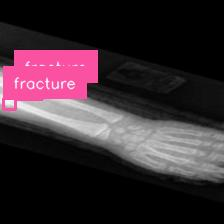
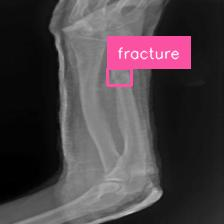
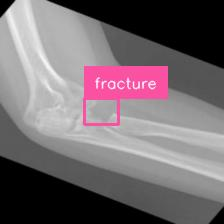
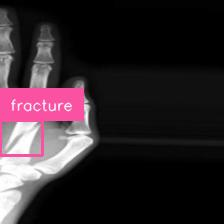

In [25]:
import base64
import html


def split_and_keep_second_part(s):
    parts = s.split("\n", 1)
    if len(parts) > 1:
        return parts[1]
    return s


def render_inline(image, resize=(128, 128)):
    """Convert image into inline html."""
    image = Image.fromarray(image)
    image.resize(resize)
    with io.BytesIO() as buffer:
        image.save(buffer, format="jpeg")
        image_b64 = str(base64.b64encode(buffer.getvalue()), "utf-8")
        return f"data:image/jpeg;base64,{image_b64}"


def render_example(image, caption):
    image = ((image + 1) / 2 * 255).astype(np.uint8)  # [-1,1] -> [0, 255]
    h, w, _ = image.shape
    try:
        detections = sv.Detections.from_lmm(
            lmm="paligemma", result=caption, resolution_wh=(w, h), classes=CLASSES
        )
        image = sv.BoundingBoxAnnotator().annotate(image, detections)
        image = sv.LabelAnnotator().annotate(image, detections)
    except:
        print(caption)
    return f"""
<div style="display: inline-flex; align-items: center; justify-content: center;">
    <img style="width:128px; height:128px;" src="{render_inline(image, resize=(64,64))}" />
    <p style="width:256px; margin:10px; font-size:small;">{html.escape(caption)}</p>
</div>
"""


html_out = ""
for idx, example in zip(range(4), train_data_iterator()):
    caption = postprocess_tokens(example["text"])  # detokenize model input.
    caption = split_and_keep_second_part(caption)
    html_out += render_example(example["image"], caption)

print("Training examples")
display(HTML(html_out))

In [26]:
# The main update_fn using a simple stochastic gradient descent (SGD).
@functools.partial(jax.jit, donate_argnums=(0,))
def update_fn(params, batch, learning_rate):
    imgs, txts, mask_ar = batch["image"], batch["text"], batch["mask_ar"]

    def loss_fn(params):
        text_logits, _ = model.apply(
            {"params": params}, imgs, txts[:, :-1], mask_ar[:, :-1], train=True
        )
        logp = jax.nn.log_softmax(text_logits, axis=-1)

        # The model takes as input txts[:, :-1] but the loss is defined as predicting
        # next tokens txts[:, 1:]. Additionally, mask_loss[:, 1:] indicates which tokens
        # are part of the loss (e.g. prefix and padded tokens are not included).
        mask_loss = batch["mask_loss"][:, 1:]
        targets = jax.nn.one_hot(txts[:, 1:], text_logits.shape[-1])

        # Compute the loss per example. i.e. the mean of per token pplx.
        # Since each example has a different number of tokens we normalize it.
        token_pplx = jnp.sum(logp * targets, axis=-1)  # sum across vocab_size.
        example_loss = -jnp.sum(token_pplx * mask_loss, axis=-1)  # sum across seq_len.
        example_loss /= jnp.clip(jnp.sum(mask_loss, -1), 1)  # weight by num of tokens.

        # batch_loss: mean of per example loss.
        return jnp.mean(example_loss)

    loss, grads = jax.value_and_grad(loss_fn)(params)

    # Apply gradients to trainable params using SGD.
    def apply_grad(param, gradient, trainable):
        if not trainable:
            return param
        return param - learning_rate * gradient

    params = jax.tree_util.tree_map(apply_grad, params, grads, trainable_mask)

    return params, loss


# Evaluation/inference loop.
def make_predictions(
    data_iterator, *, num_examples=None, batch_size=4, seqlen=SEQLEN, sampler="greedy"
):
    outputs = []
    while True:
        # Construct a list of examples in the batch.
        examples = []
        try:
            for _ in range(batch_size):
                examples.append(next(data_iterator))
                examples[-1]["_mask"] = np.array(True)  # Indicates true example.
        except StopIteration:
            if len(examples) == 0:
                return outputs

        # Not enough examples to complete a batch. Pad by repeating last example.
        while len(examples) % batch_size:
            examples.append(dict(examples[-1]))
            examples[-1]["_mask"] = np.array(False)  # Indicates padding example.

        # Convert list of examples into a dict of np.arrays and load onto devices.
        batch = jax.tree.map(lambda *x: np.stack(x), *examples)
        batch = big_vision.utils.reshard(batch, data_sharding)

        # Make model predictions
        tokens = decode(
            {"params": params}, batch=batch, max_decode_len=seqlen, sampler=sampler
        )

        # Fetch model predictions to device and detokenize.
        tokens, mask = jax.device_get((tokens, batch["_mask"]))
        tokens = tokens[mask]  # remove padding examples.
        labels = [postprocess_tokens(e["label"]) for e in examples]
        responses = [postprocess_tokens(t) for t in tokens]

        # Append to html output.
        for example, label, response in zip(examples, labels, responses):
            outputs.append((example["image"], label, response))
            if num_examples and len(outputs) >= num_examples:
                return outputs


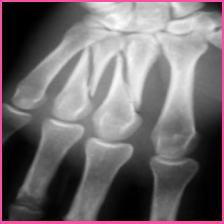
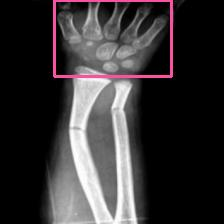
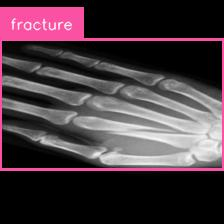
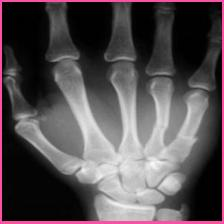

In [27]:
html_out = ""
for image, _, caption in make_predictions(
    validation_data_iterator(), num_examples=4, batch_size=4
):
    html_out += render_example(image, caption)
display(HTML(html_out))

step:  1/2500   lr: 0.00004   loss: 4.5039
step:  2/2500   lr: 0.00008   loss: 4.2838
step:  3/2500   lr: 0.00012   loss: 4.2393
step:  4/2500   lr: 0.00016   loss: 4.0956
step:  5/2500   lr: 0.00020   loss: 3.9765
step:  6/2500   lr: 0.00024   loss: 3.8618
step:  7/2500   lr: 0.00028   loss: 4.1184
step:  8/2500   lr: 0.00032   loss: 3.9508
step:  9/2500   lr: 0.00036   loss: 3.9389
step: 10/2500   lr: 0.00040   loss: 3.8008
step: 11/2500   lr: 0.00044   loss: 3.9319
step: 12/2500   lr: 0.00048   loss: 3.5041
step: 13/2500   lr: 0.00052   loss: 3.9251
step: 14/2500   lr: 0.00056   loss: 3.6179
step: 15/2500   lr: 0.00060   loss: 3.8871
step: 16/2500   lr: 0.00064   loss: 4.0714
step: 17/2500   lr: 0.00068   loss: 3.9244
step: 18/2500   lr: 0.00072   loss: 3.8104
step: 19/2500   lr: 0.00076   loss: 3.6383
step: 20/2500   lr: 0.00080   loss: 3.8834
step: 21/2500   lr: 0.00084   loss: 3.4474
step: 22/2500   lr: 0.00088   loss: 3.6909
step: 23/2500   lr: 0.00092   loss: 3.6602
step: 24/25


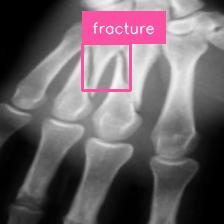
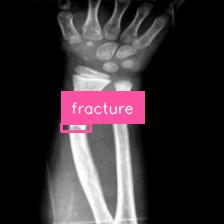
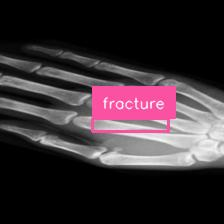
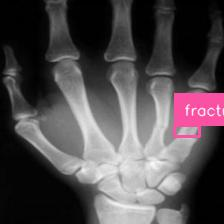

step: 313/2500   lr: 0.00998   loss: 3.2723
step: 314/2500   lr: 0.00998   loss: 3.0805
step: 315/2500   lr: 0.00998   loss: 3.4965
step: 316/2500   lr: 0.00998   loss: 3.4096
step: 317/2500   lr: 0.00998   loss: 3.3652
step: 318/2500   lr: 0.00998   loss: 3.0378
step: 319/2500   lr: 0.00998   loss: 3.3874
step: 320/2500   lr: 0.00998   loss: 3.3205
step: 321/2500   lr: 0.00998   loss: 3.0896
step: 322/2500   lr: 0.00997   loss: 3.0941
step: 323/2500   lr: 0.00997   loss: 3.2051
step: 324/2500   lr: 0.00997   loss: 3.2582
step: 325/2500   lr: 0.00997   loss: 3.4307
step: 326/2500   lr: 0.00997   loss: 3.2391
step: 327/2500   lr: 0.00997   loss: 3.0695
step: 328/2500   lr: 0.00997   loss: 3.7253
step: 329/2500   lr: 0.00997   loss: 3.1596
step: 330/2500   lr: 0.00997   loss: 3.3968
step: 331/2500   lr: 0.00997   loss: 3.3834
step: 332/2500   lr: 0.00997   loss: 3.5123
step: 333/2500   lr: 0.00997   loss: 3.3049
step: 334/2500   lr: 0.00997   loss: 3.0619
step: 335/2500   lr: 0.00996   l


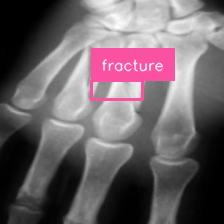
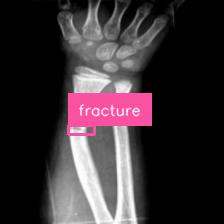
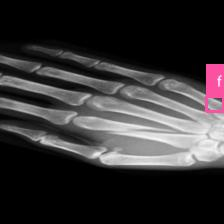
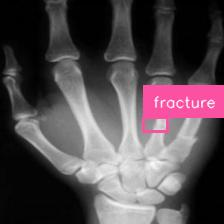

step: 625/2500   lr: 0.00933   loss: 2.8588
step: 626/2500   lr: 0.00933   loss: 2.9531
step: 627/2500   lr: 0.00932   loss: 3.3538
step: 628/2500   lr: 0.00932   loss: 3.1018
step: 629/2500   lr: 0.00932   loss: 2.9085
step: 630/2500   lr: 0.00931   loss: 2.8407
step: 631/2500   lr: 0.00931   loss: 2.9478
step: 632/2500   lr: 0.00931   loss: 2.8300
step: 633/2500   lr: 0.00930   loss: 2.6837
step: 634/2500   lr: 0.00930   loss: 2.8933
step: 635/2500   lr: 0.00930   loss: 3.0076
step: 636/2500   lr: 0.00929   loss: 2.8894
step: 637/2500   lr: 0.00929   loss: 2.9068
step: 638/2500   lr: 0.00928   loss: 3.0594
step: 639/2500   lr: 0.00928   loss: 2.9724
step: 640/2500   lr: 0.00928   loss: 2.9389
step: 641/2500   lr: 0.00927   loss: 3.0654
step: 642/2500   lr: 0.00927   loss: 2.8742
step: 643/2500   lr: 0.00927   loss: 3.0936
step: 644/2500   lr: 0.00926   loss: 3.0224
step: 645/2500   lr: 0.00926   loss: 3.2908
step: 646/2500   lr: 0.00926   loss: 3.0450
step: 647/2500   lr: 0.00925   l


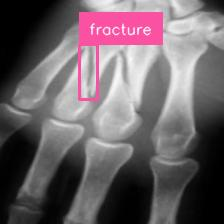
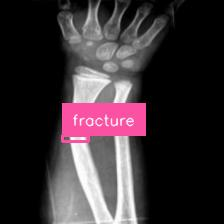
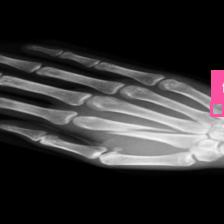
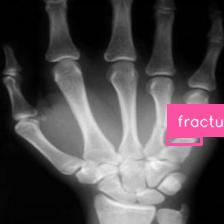

step: 937/2500   lr: 0.00787   loss: 2.9709
step: 938/2500   lr: 0.00787   loss: 2.8217
step: 939/2500   lr: 0.00786   loss: 2.7948
step: 940/2500   lr: 0.00786   loss: 2.8890
step: 941/2500   lr: 0.00785   loss: 2.6281
step: 942/2500   lr: 0.00784   loss: 2.9030
step: 943/2500   lr: 0.00784   loss: 2.8723
step: 944/2500   lr: 0.00783   loss: 2.8279
step: 945/2500   lr: 0.00783   loss: 2.7352
step: 946/2500   lr: 0.00782   loss: 2.6949
step: 947/2500   lr: 0.00782   loss: 2.6367
step: 948/2500   lr: 0.00781   loss: 2.4993
step: 949/2500   lr: 0.00780   loss: 2.4886
step: 950/2500   lr: 0.00780   loss: 2.5185
step: 951/2500   lr: 0.00779   loss: 2.5485
step: 952/2500   lr: 0.00779   loss: 2.9557
step: 953/2500   lr: 0.00778   loss: 2.7439
step: 954/2500   lr: 0.00777   loss: 2.4917
step: 955/2500   lr: 0.00777   loss: 2.5656
step: 956/2500   lr: 0.00776   loss: 2.8749
step: 957/2500   lr: 0.00776   loss: 2.9264
step: 958/2500   lr: 0.00775   loss: 2.5671
step: 959/2500   lr: 0.00775   l


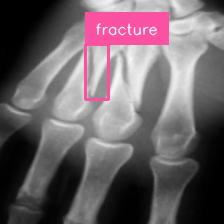
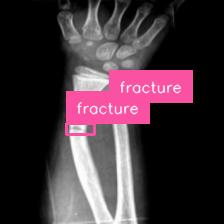
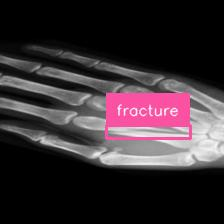
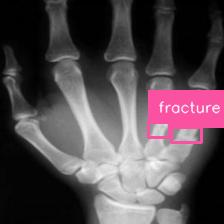

step: 1249/2500   lr: 0.00588   loss: 2.3397
step: 1250/2500   lr: 0.00587   loss: 2.4688
step: 1251/2500   lr: 0.00586   loss: 2.3571
step: 1252/2500   lr: 0.00586   loss: 2.5141
step: 1253/2500   lr: 0.00585   loss: 2.4994
step: 1254/2500   lr: 0.00584   loss: 2.6476
step: 1255/2500   lr: 0.00584   loss: 2.6033
step: 1256/2500   lr: 0.00583   loss: 2.6614
step: 1257/2500   lr: 0.00582   loss: 2.6842
step: 1258/2500   lr: 0.00582   loss: 2.3145
step: 1259/2500   lr: 0.00581   loss: 2.5979
step: 1260/2500   lr: 0.00580   loss: 2.3596
step: 1261/2500   lr: 0.00580   loss: 2.4603
step: 1262/2500   lr: 0.00579   loss: 2.4113
step: 1263/2500   lr: 0.00578   loss: 2.6601
step: 1264/2500   lr: 0.00577   loss: 2.3411
step: 1265/2500   lr: 0.00577   loss: 2.5145
step: 1266/2500   lr: 0.00576   loss: 2.6582
step: 1267/2500   lr: 0.00575   loss: 2.6266
step: 1268/2500   lr: 0.00575   loss: 2.5841
step: 1269/2500   lr: 0.00574   loss: 2.4141
step: 1270/2500   lr: 0.00573   loss: 2.4100
step: 1271


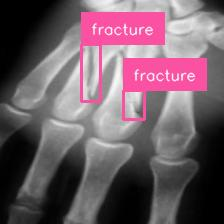
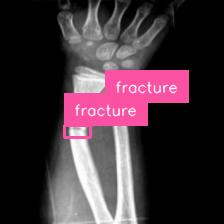
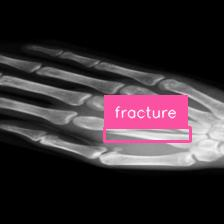
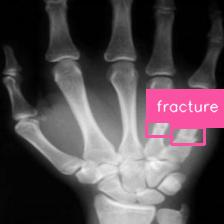

step: 1561/2500   lr: 0.00372   loss: 2.1948
step: 1562/2500   lr: 0.00371   loss: 2.1878
step: 1563/2500   lr: 0.00371   loss: 2.4079
step: 1564/2500   lr: 0.00370   loss: 2.3114
step: 1565/2500   lr: 0.00369   loss: 2.2380
step: 1566/2500   lr: 0.00369   loss: 2.0538
step: 1567/2500   lr: 0.00368   loss: 2.3691
step: 1568/2500   lr: 0.00367   loss: 2.3224
step: 1569/2500   lr: 0.00367   loss: 2.1351
step: 1570/2500   lr: 0.00366   loss: 2.2108
step: 1571/2500   lr: 0.00365   loss: 2.4610
step: 1572/2500   lr: 0.00365   loss: 2.1339
step: 1573/2500   lr: 0.00364   loss: 2.3759
step: 1574/2500   lr: 0.00363   loss: 2.4434
step: 1575/2500   lr: 0.00363   loss: 2.3189
step: 1576/2500   lr: 0.00362   loss: 2.1804
step: 1577/2500   lr: 0.00361   loss: 2.0964
step: 1578/2500   lr: 0.00361   loss: 2.2321
step: 1579/2500   lr: 0.00360   loss: 2.2526
step: 1580/2500   lr: 0.00359   loss: 2.1213
step: 1581/2500   lr: 0.00359   loss: 1.9886
step: 1582/2500   lr: 0.00358   loss: 2.1068
step: 1583


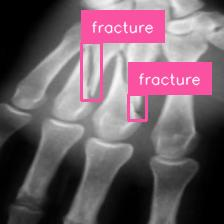
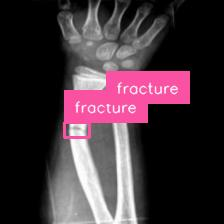
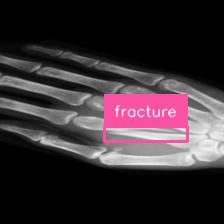
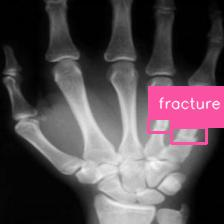

step: 1873/2500   lr: 0.00180   loss: 1.8974
step: 1874/2500   lr: 0.00180   loss: 1.8610
step: 1875/2500   lr: 0.00179   loss: 1.5338
step: 1876/2500   lr: 0.00178   loss: 1.6580
step: 1877/2500   lr: 0.00178   loss: 1.6707
step: 1878/2500   lr: 0.00177   loss: 1.7294
step: 1879/2500   lr: 0.00177   loss: 1.8581
step: 1880/2500   lr: 0.00176   loss: 2.0395
step: 1881/2500   lr: 0.00176   loss: 1.7563
step: 1882/2500   lr: 0.00175   loss: 1.7964
step: 1883/2500   lr: 0.00175   loss: 1.6211
step: 1884/2500   lr: 0.00174   loss: 1.8594
step: 1885/2500   lr: 0.00174   loss: 1.8061
step: 1886/2500   lr: 0.00173   loss: 1.7949
step: 1887/2500   lr: 0.00173   loss: 1.7135
step: 1888/2500   lr: 0.00172   loss: 2.2252
step: 1889/2500   lr: 0.00172   loss: 1.9814
step: 1890/2500   lr: 0.00171   loss: 1.7013
step: 1891/2500   lr: 0.00171   loss: 1.9498
step: 1892/2500   lr: 0.00170   loss: 1.8981
step: 1893/2500   lr: 0.00169   loss: 1.7500
step: 1894/2500   lr: 0.00169   loss: 1.8309
step: 1895


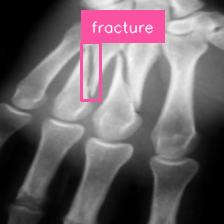
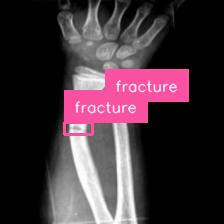
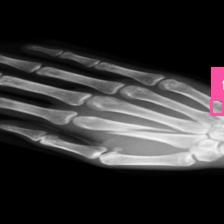
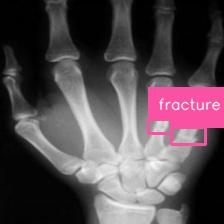

step: 2185/2500   lr: 0.00048   loss: 1.3143
step: 2186/2500   lr: 0.00048   loss: 1.2734
step: 2187/2500   lr: 0.00047   loss: 1.5233
step: 2188/2500   lr: 0.00047   loss: 1.4234
step: 2189/2500   lr: 0.00047   loss: 1.3457
step: 2190/2500   lr: 0.00046   loss: 1.4421
step: 2191/2500   lr: 0.00046   loss: 1.4789
step: 2192/2500   lr: 0.00046   loss: 1.3836
step: 2193/2500   lr: 0.00045   loss: 1.2734
step: 2194/2500   lr: 0.00045   loss: 1.4798
step: 2195/2500   lr: 0.00045   loss: 1.3801
step: 2196/2500   lr: 0.00045   loss: 1.4074
step: 2197/2500   lr: 0.00044   loss: 1.4182
step: 2198/2500   lr: 0.00044   loss: 1.2961
step: 2199/2500   lr: 0.00044   loss: 1.2808
step: 2200/2500   lr: 0.00043   loss: 1.3762
step: 2201/2500   lr: 0.00043   loss: 1.4655
step: 2202/2500   lr: 0.00043   loss: 1.2749
step: 2203/2500   lr: 0.00043   loss: 1.2972
step: 2204/2500   lr: 0.00042   loss: 1.4278
step: 2205/2500   lr: 0.00042   loss: 1.3431
step: 2206/2500   lr: 0.00042   loss: 1.5054
step: 2207


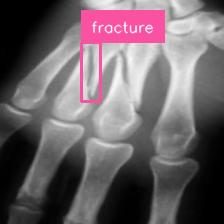
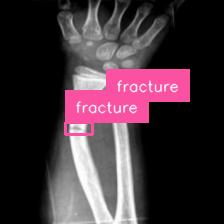
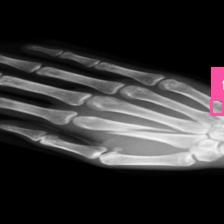
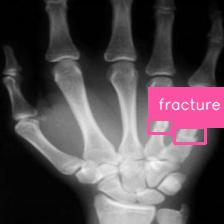

step: 2497/2500   lr: 0.00000   loss: 1.3001
step: 2498/2500   lr: 0.00000   loss: 1.1575
step: 2499/2500   lr: 0.00000   loss: 1.1674
step: 2500/2500   lr: 0.00000   loss: 1.2463


In [28]:
# Run a short training loop with cosine learning rate schedule.
#
# Note: the first step can be quite slow on some machines (up to several minutes)
# due to XLA compilation of the jax.jit'd function.
#


BATCH_SIZE = 8
TRAIN_EXAMPLES = 20_000
LEARNING_RATE = 0.01

TRAIN_STEPS = TRAIN_EXAMPLES // BATCH_SIZE
EVAL_STEPS = TRAIN_STEPS // 8

train_data_it = train_data_iterator()

sched_fn = big_vision.utils.create_learning_rate_schedule(
    total_steps=TRAIN_STEPS + 1,
    base=LEARNING_RATE,
    decay_type="cosine",
    warmup_percent=0.10,
)

for step in range(1, TRAIN_STEPS + 1):
    # Make list of N training examples.
    examples = [next(train_data_it) for _ in range(BATCH_SIZE)]

    # Convert list of examples into a dict of np.arrays and load onto devices.
    batch = jax.tree.map(lambda *x: np.stack(x), *examples)
    batch = big_vision.utils.reshard(batch, data_sharding)

    # Training step and report training loss
    learning_rate = sched_fn(step)
    params, loss = update_fn(params, batch, learning_rate)

    loss = jax.device_get(loss)
    print(
        f"step: {step:2d}/{TRAIN_STEPS:2d}   lr: {learning_rate:.5f}   loss: {loss:.4f}"
    )

    if (step % EVAL_STEPS) == 0:
        print(f"Model predictions at step {step}")
        html_out = ""
        for image, _, caption in make_predictions(
            validation_data_iterator(), num_examples=4, batch_size=4
        ):
            html_out += render_example(image, caption)
        display(HTML(html_out))


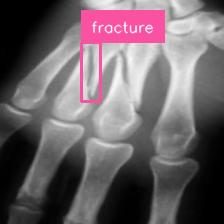
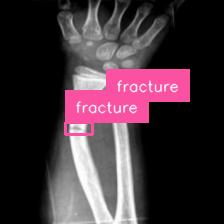
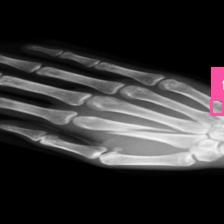
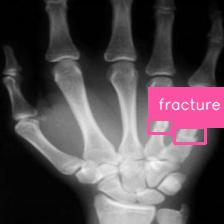
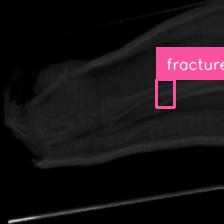
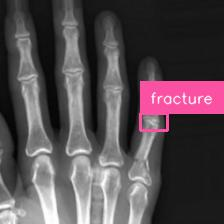
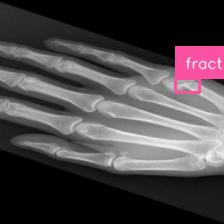
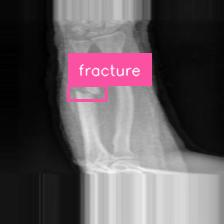
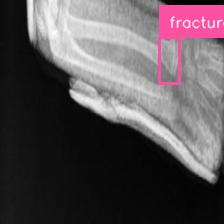
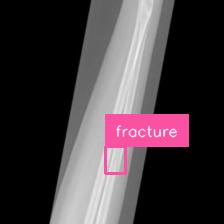
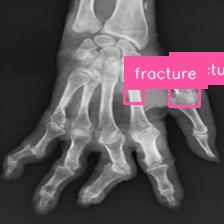
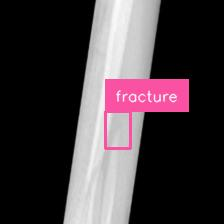
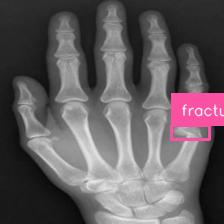
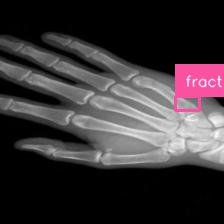
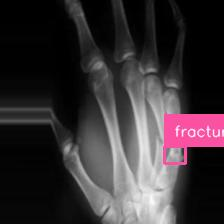
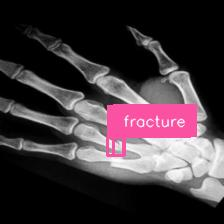

In [29]:
# @title Visualize results
html_out = ""
for image, _, caption in make_predictions(
    validation_data_iterator(), num_examples=16, batch_size=8
):
    html_out += render_example(image, caption)
display(HTML(html_out))

In [30]:
# @title Collect predictions
targets = []
predictions = []

for image, label, prediction in make_predictions(
    validation_data_iterator(), num_examples=512, batch_size=8
):
    h, w, _ = image.shape
    target = sv.Detections.from_lmm(
        lmm="paligemma", result=label, resolution_wh=(w, h), classes=CLASSES
    )
    targets.append(target)
    prediction = sv.Detections.from_lmm(
        lmm="paligemma", result=prediction, resolution_wh=(w, h), classes=CLASSES
    )
    prediction.confidence = np.ones(len(prediction))
    predictions.append(prediction)

2024-06-06 07:22:09.296049: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [31]:
# compute mAP
mean_average_precision = sv.MeanAveragePrecision.from_detections(
    predictions=predictions,
    targets=targets,
)

print(f"map50_95: {mean_average_precision.map50_95:.2f}")
print(f"map50: {mean_average_precision.map50:.2f}")
print(f"map75: {mean_average_precision.map75:.2f}")

map50_95: 0.19
map50: 0.44
map75: 0.13


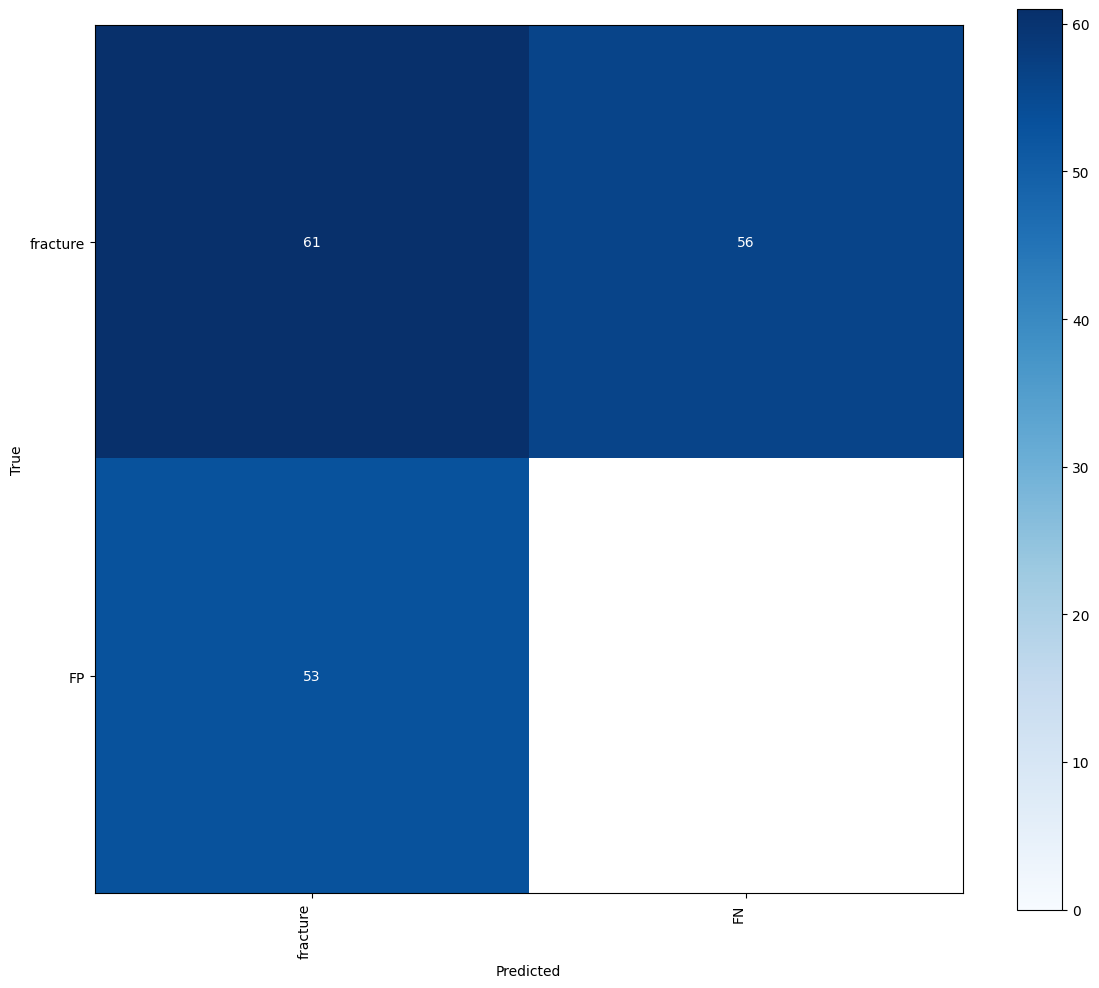

In [32]:
confusion_matrix = sv.ConfusionMatrix.from_detections(
    predictions=predictions, targets=targets, classes=CLASSES
)

_ = confusion_matrix.plot()

In [33]:
import os

TARGET_MODEL_DIR = f"{dataset.location}/model"
TARGET_MODEL_PATH = f"{TARGET_MODEL_DIR}/paligemma-3b-pt-224.f16.npz"

os.makedirs(TARGET_MODEL_DIR, exist_ok=True)

flat, _ = big_vision.utils.tree_flatten_with_names(params)
with open(TARGET_MODEL_PATH, "wb") as f:
    np.savez(f, **{k: v for k, v in flat})